Import data for train/test

In [5]:
import pandas as pd
metadata = pd.read_csv("processed_data/processed_images.csv")
metadata.head()

,path,label
0,processed_data/images/03a01Fa.wav0.png,F
1,processed_data/images/03a01Nc.wav0.png,N
2,processed_data/images/03a01Wa.wav0.png,W
3,processed_data/images/03a02Fc.wav0.png,F
4,processed_data/images/03a02Nc.wav0.png,N


Train test data

In [8]:
# data preaparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# dealing with images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

In [9]:
# get train/test dataframe
train_df, test_df = train_test_split(metadata, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = metadata['label'])
print(f'Train {np.shape(train_df)} and test {np.shape(test_df)}')

Train (452, 2) and test (113, 2)


In [10]:
path_dir = "./"

train_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_dir,
    x_col="path",
    y_col="label",
    batch_size=32,
    shuffle=True,
    target_size=(256, 256),
    class_mode='categorical',
    subset='training'
)

Found 452 validated image filenames belonging to 7 classes.


In [11]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_dir,
    x_col="path",
    y_col="label",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(256, 256))

Found 113 validated image filenames belonging to 7 classes.


# Define a model for SER

In [21]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D, InputLayer

In [15]:
input_size = (256, 256, 3)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
batchsize = 32
epochs = 50
metrics = [
    "accuracy",
]
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
]

In [26]:
model = Sequential([
    InputLayer(input_shape=input_size),
    #1st hidden layer
    Conv2D(16, (3, 3), activation='relu', padding="same"),
    MaxPool2D((2, 2)),
    #2nd hidden layer
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding="same"),
    MaxPool2D((2, 2)),
    # 3rd conv block
    Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    #ANN
    Flatten(),
    Dropout(0.2),
    Dense(units = 128, activation='relu'),
    Dense(units = 64, activation='relu'),
    #Output layer
    Dense(units= 7, activation='softmax'),
]) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=metrics)

In [28]:
history = model.fit(train_generator,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_data=test_generator,
                    callbacks=callbacks)

Epoch 1/50
15/15 [==============================] - 8s 368ms/step - loss: 1.9106 - accuracy: 0.2367 - val_loss: 1.8699 - val_accuracy: 0.3009
Epoch 2/50
15/15 [==============================] - 3s 175ms/step - loss: 1.7195 - accuracy: 0.3717 - val_loss: 1.6148 - val_accuracy: 0.4248
Epoch 3/50
15/15 [==============================] - 3s 184ms/step - loss: 1.4775 - accuracy: 0.4226 - val_loss: 1.4450 - val_accuracy: 0.3982
Epoch 4/50
15/15 [==============================] - 3s 183ms/step - loss: 1.3501 - accuracy: 0.4757 - val_loss: 1.3512 - val_accuracy: 0.4425
Epoch 5/50
15/15 [==============================] - 3s 174ms/step - loss: 1.1727 - accuracy: 0.5354 - val_loss: 1.4787 - val_accuracy: 0.4956
Epoch 6/50
15/15 [==============================] - 3s 175ms/step - loss: 1.1666 - accuracy: 0.5465 - val_loss: 1.1984 - val_accuracy: 0.5310
Epoch 7/50
15/15 [==============================] - 3s 176ms/step - loss: 1.0372 - accuracy: 0.6106 - val_loss: 1.1955 - val_accuracy: 0.5133
Epoch 

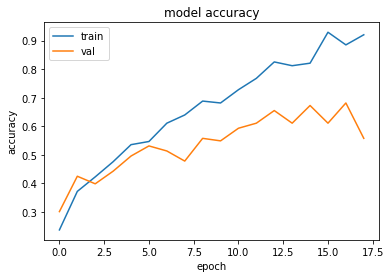

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

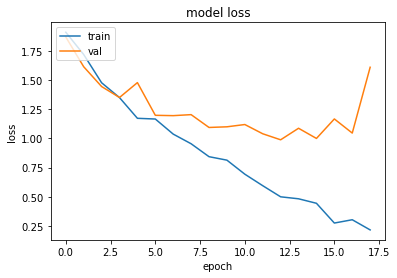

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Save the model for future computations

In [33]:
model.save('trained_models/firstCNN.h5')